# Assigment 2 - Forecasting Electricity Prices

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import model_selection
from math import sqrt
import warnings
import numpy as np
import os
import pandas as pd
import datetime as dt

warnings.filterwarnings("ignore")

In [2]:
# Prøver lige noget fancy gpu acceleration

import torch
import torch.nn as nn

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

No GPU available. Training will run on CPU.
cpu


Loading in required data, and filtering according to requirements.

In [3]:
file_P = os.path.join(os.getcwd(),'data/Elspotprices2.csv')
df_prices = pd.read_csv(file_P)
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])
df_prices = df_prices.loc[(df_prices['PriceArea']=="DK2")][["HourUTC","SpotPriceDKK"]]
df_prices = df_prices.loc[df_prices["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_prices = df_prices.reset_index(drop=True)

## Task 1

### 1.1

We start by dividing the data into training- and test sets.

In [4]:
# We use the time intervial.
t_s_data = pd.Timestamp(dt.datetime(2019, 1, 1, 0, 0, 0))
t_e_data = pd.Timestamp(dt.datetime(2023, 1, 1, 0, 0, 0))

data_all = df_prices.loc[(df_prices['HourUTC'] >= t_s_data) & (df_prices['HourUTC'] <= t_e_data)]
data_all = data_all.reset_index(drop=True)

# We use the time intervial.
t_s_train = pd.Timestamp(dt.datetime(2023, 1, 1, 0, 0, 0))
t_e_train = pd.Timestamp(dt.datetime(2023, 11, 30, 23, 0, 0))

train = df_prices.loc[(df_prices['HourUTC'] >= t_s_train) & (df_prices['HourUTC'] <= t_e_train)]
train = train.reset_index(drop=True)

t_s_test = pd.Timestamp(dt.datetime(2023, 12, 1, 0, 0, 0))
t_e_test= pd.Timestamp(dt.datetime(2023, 12, 31, 23, 0, 0))

test = df_prices.loc[(df_prices['HourUTC'] >= t_s_test) & (df_prices['HourUTC'] <= t_e_test)]
test = test.reset_index(drop=True)

Visualizing the sets along with past data

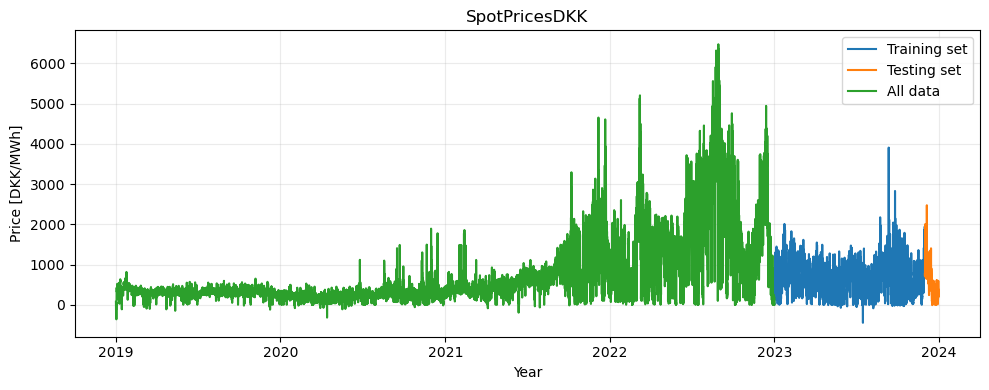

In [5]:

plt.figure(figsize=(10, 4), dpi=100)

plt.plot(train['HourUTC'], train['SpotPriceDKK'])
plt.plot(test['HourUTC'], test['SpotPriceDKK'])
plt.plot(data_all['HourUTC'], data_all['SpotPriceDKK'], alpha=1)


plt.title('SpotPricesDKK')
plt.xlabel('Year')
plt.ylabel('Price [DKK/MWh]')

plt.legend(["Training set", "Testing set" , "All data"])
plt.tight_layout()
plt.grid(alpha=0.25)
plt.show()

We will first remove all the columns other than the numerical values for SpotPricesDKK.
We use auto_arima to automatically determine ARIMA parameters.

In [6]:
train_Arima = train['SpotPriceDKK']
test_Arima = test['SpotPriceDKK']

# Automatically fit the ARIMA model
# model = pm.auto_arima(train_Arima, seasonal = True, trace = True, maxiter = 15, stepwise = True, method = 'nm', m = 24)
model = pm.arima.ARIMA(order=(2,1,0), seasonal_order=(1,0,1,24)) 
model.fit(train_Arima)


# Here the optimal model was found through auto_arima(), but later fit manually to save time during testing

ARIMA(order=(2, 1, 0), seasonal_order=(1, 0, 1, 24))

In [9]:
# Day-ahead prediction
pred = []

for i in range(0, len(test_Arima), 24):
    # Predict next 24 values in test set
    pred_temp = model.predict(24)
    pred.extend(pred_temp)
    
    # Update model with actual values for the next 24 time steps in one go
    model.update(test_Arima[i:i+24])

For comparison, a simple persistence model is created.

In [10]:
pers = np.zeros(len(test_Arima)).tolist()

for i in range(24, len(test_Arima), 24):
    for j in range(24):
        pers[i+j] = test_Arima[(i-24)+j]

The test data is plotted along with the ARIMA predictions and the persistence model.

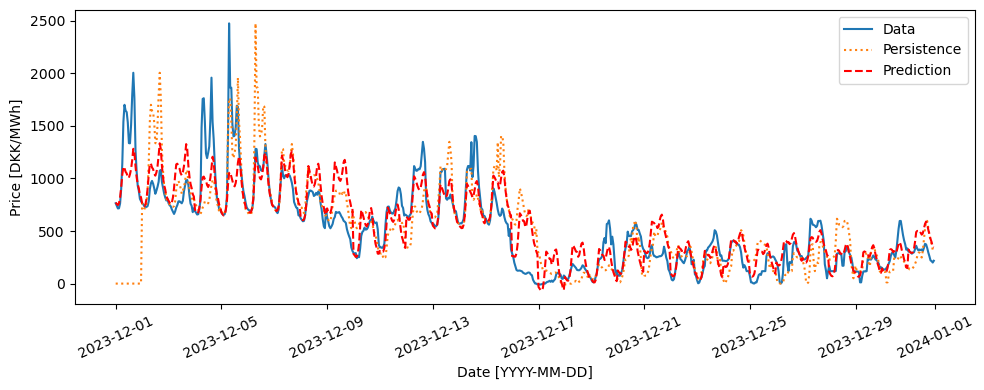

In [11]:
plt.figure(figsize=(10, 4), dpi=100)
plt.plot(test['HourUTC'], test_Arima, label='Data')
plt.plot(test['HourUTC'], pers, label='Persistence', linestyle="dotted")
plt.plot(test['HourUTC'], pred, label='Prediction', linestyle="dashed", color="red")
plt.legend()
plt.ylabel('Price [DKK/MWh]')
plt.xlabel('Date [YYYY-MM-DD]')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

The error metrics for both are calculated.

In [12]:
# Calculate error metrics
RMSE_AR_pred = sqrt(mean_squared_error(test_Arima, pred))
MAE_AR_pred = mean_absolute_error(test_Arima, pred)
print('Prediction')
print('\t Root-mean-square error: ', round(RMSE_AR_pred,2))
print('\t Mean absolute error: ', round(MAE_AR_pred,2))

print('')

RMSE_AR_pers = sqrt(mean_squared_error(test_Arima, pers))
MAE_AR_pers = mean_absolute_error(test_Arima, pers)
print('Persistence')
print('\t Root-mean-square error: ', round(RMSE_AR_pers,2))
print('\t Mean absolute error: ', round(MAE_AR_pers,2))

Prediction
	 Root-mean-square error:  211.36
	 Mean absolute error:  145.0

Persistence
	 Root-mean-square error:  339.24
	 Mean absolute error:  214.76


This shows that the day-ahead prediction with no exogenous variables is a little better than simply assuming the same values as the previous day.

### 1.2

Loading in the data with exogenous variables.

In [13]:
file_P = os.path.join(os.getcwd(),'data/ProdConData.csv')
df_data = pd.read_csv(file_P)
df_data["HourUTC"] = pd.to_datetime(df_data["HourUTC"])
df_data = df_data.loc[df_data["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_data = df_data.loc[df_data["PriceArea"].isin(["DK2"])]
df_data = df_data.dropna(axis=1)
df_data = df_data.reset_index(drop=True)

In [14]:
# Which variables do we have to choose from?
for col in df_data.columns:
    print(col)

HourUTC
HourDK
PriceArea
CentralPowerMWh
LocalPowerMWh
LocalPowerSelfConMWh
OffshoreWindLt100MW_MWh
OffshoreWindGe100MW_MWh
OnshoreWindLt50kW_MWh
OnshoreWindGe50kW_MWh
HydroPowerMWh
SolarPowerLt10kW_MWh
SolarPowerGe10Lt40kW_MWh
SolarPowerGe40kW_MWh
SolarPowerSelfConMWh
ExchangeSE_MWh
ExchangeGE_MWh
ExchangeGreatBelt_MWh
GrossConsumptionMWh
GridLossTransmissionMWh
PowerToHeatMWh


Choosing exogenous variables

In [15]:
train.insert(2, 'ExchangeSE_MWh', df_data['ExchangeSE_MWh'])
train.insert(3, 'GrossConsumptionMWh', df_data['GrossConsumptionMWh'])
# train.insert(3, 'OnshoreWindGe50kW_MWh', df_data['OnshoreWindGe50kW_MWh'])

train = train.drop(columns=['HourUTC', 'SpotPriceDKK'])

print('Exogenous variables chosen: ')

for col in train.columns:
    print('\t', col)

Exogenous variables chosen: 
	 ExchangeSE_MWh
	 GrossConsumptionMWh


Fitting the model with the exogenous variables

In [16]:
X_train_ar = np.column_stack([np.arange(1, len(train_Arima)+1), train_Arima])

model.fit(train_Arima, X = X_train_ar)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 8016
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 24)   Log Likelihood               84896.514
Date:                              Tue, 16 Apr 2024   AIC                        -169777.027
Time:                                      12:41:04   BIC                        -169721.115
Sample:                                           0   HQIC                       -169757.891
                                             - 8016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.559e-16   1.37e-24  -3.34e+08      0.000   -4.56e-16   -4.56e-16
x1          1.523e-15   1.14e-25   1.34e+10      0.000    1.52e-15    1.52e-15
x2             1.0000   8.44e-22   1.18e+21      0.000       1.000       1.000
ar.L1          0.3934   7.01e-24   5.61e+22      0.000       0.393       0.393
ar.L2         -0.0947   2.83e-25  -3.34e+23      0.000      -0.095      -0.095
ar.S.L24       0.8763   2.81e-22   3.12e+21      0.000       0.876       0.876
ma.S.L24      -0.6724   1.19e-22  -5.64e+21      0.000      -0.672      -0.672
sigma2          1e-10   2.21e-11      4.517      0.000    5.66e-11    1.43e-10
===================================================================================
Ljung-Box (L1) (Q):                2115.60   Jarque-Bera (JB):             18148.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.46
Prob(H) (two-sided):                  0.66   Kurtosis:                        10.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+44. Standard errors may be unstable.
"""

Day-ahead prediction with exogenous variables

In [17]:
# Day-ahead prediction
pred_exog = []
X_f = train[:24]

for i in range(0, len(test_Arima), 24):
    # Predict next 24 values for all time series at once
    pred_temp = model.predict(24, X_f)
    pred_exog.extend(pred_temp)
    
    # Update model with actual values for the next 24 time steps in one go
    model.update(test_Arima[i:i+24], X_f)

Visualizing the results

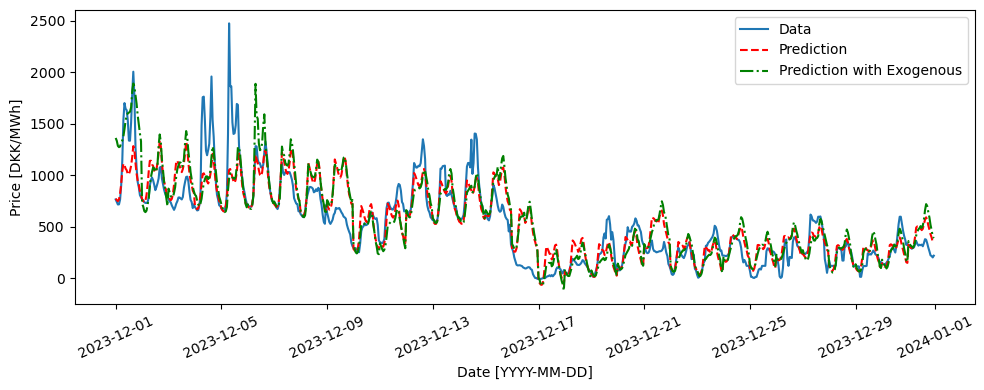

In [18]:
plt.figure(figsize=(10, 4), dpi=100)
plt.plot(test['HourUTC'], test_Arima, label='Data')
plt.plot(test['HourUTC'], pred, label='Prediction', linestyle="dashed", color="red")
plt.plot(test['HourUTC'], pred_exog, label='Prediction with Exogenous', linestyle="dashdot", color="green")

plt.legend()
plt.ylabel('Price [DKK/MWh]')
plt.xlabel('Date [YYYY-MM-DD]')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

Calculating error metrics

In [19]:
RMSE_AR_pred = sqrt(mean_squared_error(test_Arima, pred_exog))
MAE_AR_pred = mean_absolute_error(test_Arima, pred_exog)
print('Prediction')
print('\t Root-mean-square error: ', round(RMSE_AR_pred,2))
print('\t Mean absolute error: ', round(MAE_AR_pred,2))

Prediction
	 Root-mean-square error:  229.75
	 Mean absolute error:  162.21


Finally Saving the predictions

In [8]:
np.save('data/pred_exog.npy', pred_exog)
np.save('data/pred.npy', pred)
np.save('data/test_Arima.npy', test_Arima)

### LSTM PART

In [ ]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.activations import relu
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import load_model

Load the Elspotprices Data

In [ ]:
# We load the spot prices
file_Path = os.path.join(os.getcwd(),'Elspotprices2.csv')
df_prices = pd.read_csv(file_Path)

# We convert the HourUTC column to datetime and set the column only at the DK2 price area
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])
df_prices = df_prices.loc[(df_prices['PriceArea']=="DK2")][["HourUTC","SpotPriceDKK"]]
df_prices = df_prices.loc[df_prices["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_prices = df_prices.reset_index(drop=True)

Define the train, val and test set

In [ ]:

sc = MinMaxScaler(feature_range=(0, 1))

data_training = sc.fit_transform(df_prices["SpotPriceDKK"].values.reshape(-1,1))


start_date_test = pd.to_datetime('2023-11-27 00:00:00')
end_date_test = pd.to_datetime('2023-12-31 23:00:00')

start_date_train = pd.to_datetime('2019-01-01 00:00:00')
end_date_train = pd.to_datetime('2023-08-07 23:00:00')

start_date_val = pd.to_datetime('2023-8-01 00:00:00')
end_date_val = pd.to_datetime('2023-12-31 23:00:00')

train_data = df_prices.loc[(df_prices['HourUTC']>=start_date_train) & (df_prices['HourUTC']<=end_date_train)]
train_datav = train_data
train_data = sc.fit_transform(train_data["SpotPriceDKK"].values.reshape(-1,1))  

test_data = df_prices.loc[(df_prices['HourUTC']>=start_date_test) & (df_prices['HourUTC']<=end_date_test)]
test_datav = test_data
test_data = sc.transform(test_data["SpotPriceDKK"].values.reshape(-1,1))

val_data = df_prices.loc[(df_prices['HourUTC']>=start_date_val) & (df_prices['HourUTC']<=end_date_val)]
val_datav = val_data
val_data = sc.transform(val_data["SpotPriceDKK"].values.reshape(-1,1))



Split data in sequences 

In [ ]:
look_back = (24*3) # Number of previous time steps to use as input features
look_ahead = 24# Number of time steps to look ahead


def create_sequences(data, seq_length, pred_length):
    X = []
    y = []

    for i in range(len(data) - seq_length - pred_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[(i + seq_length):(i + seq_length + pred_length)])

    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, look_back, look_ahead)
X_test, y_test = create_sequences(test_data, look_back, look_ahead)
X_val, y_val = create_sequences(val_data, look_back, look_ahead)


n_train = len(X_train)
n_val = len(X_val)
n_test = len(X_test)
n_data = len(df_prices)

print(f"Training samples: {n_train}")
print(f"Validation samples: {n_val}")
print(f"Testing samples: {n_test}")
print(f"Total samples: {n_data}")


Buld and train the model

In [ ]:

dropout = 0.2
# Reshape input data for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
"""
ephoc_idx = np.argmin(rmse_index)
ephoc_best = ephochs[ephoc_idx]
"""
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), recurrent_dropout=dropout, dropout=dropout)) # bedre uden activation="relu",
print(X_train.shape[1])
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=4, batch_size=32, validation_data=(X_val, y_val))#validation_data=(X_val, y_val)



make prediction and plot

In [ ]:

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_pred = model.predict(X_test) 


last_x_prices = df_prices['SpotPriceDKK'].iloc[-(len(X_test)+24):]

y_test_org = np.array([])

# Append the last 798 values to the new array
y_test_org = np.append(y_test_org, last_x_prices)

y_test = np.squeeze(y_test)
y_test_orginal = sc.inverse_transform(y_test)
predicted_consumption = sc.inverse_transform(y_pred)

y_avage_pred = np.mean(predicted_consumption, axis=1)

plt.figure(figsize=(10, 4))
plt.plot(y_test_orginal[:, 1] , label='True spot price')
plt.plot(predicted_consumption, label='Predicted spot price')
#plt.plot(pers, label='Presistance')
plt.xlabel('Hour')
plt.ylabel('spot price (DKK/MWh)')
plt.legend()
plt.show()

Plot training and validation loss

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Errors for real data

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import load_model
mse = mean_squared_error(y_test_orginal[:, 1], predicted_consumption)
mae = mean_absolute_error(y_test_orginal[:, 1], predicted_consumption)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_orginal[:, 1], predicted_consumption)

#print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Errors for persitance

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import load_model
mse = mean_squared_error(y_test_orginal[:, 1], pers)
mae = mean_absolute_error(y_test_orginal[:, 1], pers)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_orginal[:, 1], pers)
print("presitance")
#print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Save data

In [ ]:
np.save('pred_LTSMEXOG1.npy', predicted_consumption)
np.save('true_LTSMEXOG1.npy', y_test_orginal[:, 1])

### With xogenous variables

In [ ]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.activations import relu

Import Data

In [ ]:

# We load the spot prices
file_Path = os.path.join(os.getcwd(),'Elspotprices2.csv')
df_prices = pd.read_csv(file_Path)

# We convert the HourUTC column to datetime and set the column only at the DK2 price area
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])
df_prices = df_prices.loc[(df_prices['PriceArea']=="DK2")][["HourUTC","SpotPriceDKK"]]
df_prices = df_prices.loc[df_prices["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_prices = df_prices.reset_index(drop=True)

# We load the production and consumption data
file_Path = os.path.join(os.getcwd(),'ProdConData.csv')
df_data = pd.read_csv(file_Path)

# "e convert the HourUTC column to datetime
df_data["HourUTC"] = pd.to_datetime(df_data["HourUTC"])
df_data = df_data.loc[(df_data['PriceArea']=="DK2")]#[["HourUTC","ExchangeSE_MWh","GrossConsumptionMWh","OffshoreWindGe100MW_MWh"]]
df_data = df_data.loc[df_data["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_data = df_data.reset_index(drop=True)


Mearge data and chose fetures

In [ ]:

data_mearge = pd.merge(df_prices, df_data, on='HourUTC')

data_mearge = data_mearge[["HourUTC", "SpotPriceDKK", "OnshoreWindGe50kW_MWh","ExchangeSE_MWh","GrossConsumptionMWh"]]


nr_features = 3
data_mearge['onshore'] = data_mearge['OnshoreWindGe50kW_MWh']
data_mearge['exchangeSE'] = data_mearge['ExchangeSE_MWh']
#data_mearge['consumption'] = data_mearge['GrossConsumptionMWh']
data_mearge = data_mearge.drop(['OnshoreWindGe50kW_MWh','ExchangeSE_MWh','GrossConsumptionMWh'], axis=1)

sc = MinMaxScaler(feature_range=(0, 1))
scy = MinMaxScaler(feature_range=(0, 1))


Define Sets

In [ ]:

start_date_train = pd.to_datetime('2019-01-01 00:00:00')
end_date_train = pd.to_datetime('2023-8-07 23:00:00')

start_date_val = pd.to_datetime('2023-8-01 00:00:00')
end_date_val = pd.to_datetime('2023-12-31 23:00:00')

start_date_test = pd.to_datetime('2023-11-28 00:00:00')
end_date_test = pd.to_datetime('2023-12-31 23:00:00')

train_data = data_mearge.loc[(data_mearge['HourUTC']>=start_date_train) & (data_mearge['HourUTC']<=end_date_train)]
print(train_data.shape)
train_data = sc.fit_transform(train_data[["SpotPriceDKK", 'exchangeSE',  'onshore']]) #'consumption',
print(train_data.shape)
test_data = data_mearge.loc[(data_mearge['HourUTC']>=start_date_test) & (data_mearge['HourUTC']<=end_date_test)]
test_data = sc.fit_transform(test_data[["SpotPriceDKK", 'exchangeSE',  'onshore']])#'consumption','onshore''exchangeSE',


Define Seqenses

In [ ]:

look_back = (24*3) # Number of previous time steps to use as input features
look_ahead = 24# Number of time steps to look ahead


def create_sequences(data, seq_length, pred_length):
    X = []
    y = []

    for i in range(len(data) - seq_length - pred_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[(i + seq_length):(i + seq_length + pred_length), 0])

    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, look_back, look_ahead)
X_test, y_test = create_sequences(test_data, look_back, look_ahead)
X_val, y_val = create_sequences(train_data, look_back, look_ahead)


n_train = len(X_train)
n_val = len(X_val)
n_test = len(X_test)
n_data = len(df_prices)

print(f"Training samples: {n_train}")
print(f"Validation samples: {n_val}")
print(f"Testing samples: {n_test}")
print(f"Total samples: {n_data}")


Define model and train

In [ ]:

dropout = 0.2
# Reshape input data for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], nr_features))
#X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], nr_features),  recurrent_dropout=dropout, dropout=dropout)) # activation="relu",
print(X_train.shape[1])
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=4, batch_size=32, validation_data=(X_val, y_val))#validation_data=(X_val, y_val)


Make prediction an plot

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], nr_features))
y_pred = model.predict(X_test) 

last_x_prices = df_prices['SpotPriceDKK'].iloc[-(len(X_test)+24):]

inv_ref = scy.fit_transform(last_x_prices.values.reshape(-1,1))

y_test_org = np.array([])

# Append the last 798 values to the new array
y_test_org = np.append(y_test_org, last_x_prices)

y_test = np.squeeze(y_test)
y_test_orginal = scy.inverse_transform(y_test)
predicted_consumption = scy.inverse_transform(y_pred)

y_avage_pred = np.mean(predicted_consumption, axis=1)
# make presitance model
pers = np.roll(y_test_orginal[:, 1], 24)
#plt.plot(y_test_org)
plt.figure(figsize=(10, 4))
plt.plot(y_test_orginal[:, 1] , label='True spot price')
plt.plot(predicted_consumption, label='Predicted spot price')
plt.plot(pers, label='Presistance')
plt.xlabel('Hour')
plt.ylabel('spot price (DKK/MWh)')
plt.legend()
plt.show()

Plot training and validation loss

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Error for prediction

In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import load_model
mse = mean_squared_error(y_test_orginal[:, 1], predicted_consumption)
mae = mean_absolute_error(y_test_orginal[:, 1], predicted_consumption)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_orginal[:, 1], predicted_consumption)

#print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)


Error for presistence

In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import load_model
mse = mean_squared_error(y_test_orginal[:, 1], pers)
mae = mean_absolute_error(y_test_orginal[:, 1], pers)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_orginal[:, 1], pers)
print("presitance")
#print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)



Save Data

In [ ]:
#np.save('pred_LTSMEXOG1.npy', predicted_consumption)
#np.save('true_LTSMEXOG1.npy', y_test_orginal[:, 1])

### xogenous variables as forcasting

In [ ]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.activations import relu
from keras.models import Model
from keras.layers import Input

Load data

In [ ]:

# We load the spot prices
file_Path = os.path.join(os.getcwd(),'Elspotprices2.csv')
df_prices = pd.read_csv(file_Path)

# We convert the HourUTC column to datetime and set the column only at the DK2 price area
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])
df_prices = df_prices.loc[(df_prices['PriceArea']=="DK2")][["HourUTC","SpotPriceDKK"]]
df_prices = df_prices.loc[df_prices["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_prices = df_prices.reset_index(drop=True)

# We load the production and consumption data
file_Path = os.path.join(os.getcwd(),'ProdConData.csv')
df_data = pd.read_csv(file_Path)

# "e convert the HourUTC column to datetime
df_data["HourUTC"] = pd.to_datetime(df_data["HourUTC"])
df_data = df_data.loc[(df_data['PriceArea']=="DK2")]#[["HourUTC","ExchangeSE_MWh","GrossConsumptionMWh","OffshoreWindGe100MW_MWh"]]
df_data = df_data.loc[df_data["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_data = df_data.reset_index(drop=True)


merge data and choose xogenous variables

In [ ]:
data_mearge = pd.merge(df_prices, df_data, on='HourUTC')

data_mearge = data_mearge[["HourUTC", "SpotPriceDKK", "OnshoreWindGe50kW_MWh","ExchangeSE_MWh","GrossConsumptionMWh"]]


# overvej om den er shiftet rigtigt 
#data_mearge['onshore'] = data_mearge['OnshoreWindGe50kW_MWh'].shift(-look_ahead)
data_mearge['exchangeSE'] = data_mearge['ExchangeSE_MWh'].shift(-look_ahead)
data_mearge['consumption'] = data_mearge['GrossConsumptionMWh'].shift(-look_ahead)
data_mearge = data_mearge.drop(['OnshoreWindGe50kW_MWh','ExchangeSE_MWh','GrossConsumptionMWh'], axis=1)

sc1 = MinMaxScaler(feature_range=(0, 1))
sc2 = MinMaxScaler(feature_range=(0, 1))


Define sets 

Note no val as it gets to wird

In [ ]:
_date_test = pd.to_datetime('2023-11-30 00:00:00')
start_date_test2 = pd.to_datetime('2023-11-30 00:00:00')
end_date_test = pd.to_datetime('2023-12-31 23:00:00')

end_date_train2 = pd.to_datetime('2023-12-01 00:00:00')
start_date_train = pd.to_datetime('2019-01-01 00:00:00')
end_date_train = pd.to_datetime('2023-11-30 23:00:00')

train_data = data_mearge.loc[(data_mearge['HourUTC']>=start_date_train) & (data_mearge['HourUTC']<=end_date_train)]
print(train_data.shape)
train_data = sc1.fit_transform(train_data[["SpotPriceDKK"]]) 
print(train_data.shape)
test_data = data_mearge.loc[(data_mearge['HourUTC']>=start_date_test) & (data_mearge['HourUTC']<=end_date_test)]
test_data = sc1.fit_transform(test_data[["SpotPriceDKK"]])

train_data2 = data_mearge.loc[(data_mearge['HourUTC']>=start_date_train) & (data_mearge['HourUTC']<=end_date_train2)]
train_data2 = sc2.fit_transform(train_data2[[ 'exchangeSE', 'consumption']])
print(train_data2.shape)

test_data2 = data_mearge.loc[(data_mearge['HourUTC']>=start_date_test2) & (data_mearge['HourUTC']<=end_date_test)]
test_data2 = sc2.fit_transform(test_data2[['exchangeSE', 'consumption']])
print(test_data2.shape)


Create seqenses

In [ ]:
look_back = (24*1) # Number of previous time steps to use as input features
look_ahead = 24# Number of time steps to look ahead


def create_sequences(data, seq_length, pred_length):
    X = []
    y = []

    for i in range(len(data) - seq_length - pred_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[(i + seq_length):(i + seq_length + pred_length), 0])

    return np.array(X), np.array(y)

X_train1, y_train1 = create_sequences(train_data, look_back, look_ahead)
X_test1, y_test1 = create_sequences(test_data, look_back, look_ahead)

X_train2, y_train2 = create_sequences(train_data2, 24, look_ahead)
X_test2, y_test2 = create_sequences(test_data2, 24, look_ahead)



n_train1 = len(X_train1)
n_train2 = len(X_train2)
#n_val = len(X_val)
n_test = len(X_test1)
n_data = len(df_prices)

print(f"Training samples: {n_train1}")
print(f"Training samples: {n_train2}")
#print(f"Validation samples: {n_val}")
print(f"Testing samples: {n_test}")
print(f"Total samples: {n_data}")


Define models, mearge, and train

In [ ]:

dropout = 0.2
# Reshape input data for LSTM [samples, time steps, features]
X1_train = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], 1))
X2_train = np.reshape(X_train2, (X_train2.shape[0], X_train2.shape[1], 2))



# Define the shape of the two inputs
input_shape1 = (X1_train.shape[1], X1_train.shape[2])
input_shape2 = (X2_train.shape[1], X2_train.shape[2])

# Create the two input layers
input1 = Input(shape=input_shape1)
input2 = Input(shape=input_shape2)


# Create LSTM layers for each input
lstm1 = LSTM(units=look_ahead, return_sequences=False, recurrent_dropout=dropout, dropout=dropout)(input1)
lstm2 = LSTM(units=look_ahead, return_sequences=False, recurrent_dropout=dropout, dropout=dropout)(input2)

# Merge the output of the two LSTM layers
merged = keras.layers.concatenate([lstm1, lstm2])
from keras.layers import Reshape

# Add a Reshape layer to add an extra dimension
merged = Reshape((1, -1))(merged)

# Now you can feed the reshaped input into the LSTM layer
merged = LSTM(units=look_ahead)(merged)


# Add a Dense layer to make the final prediction
output = Dense(units=1)(merged)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

X2_train = X2_train[:-1]
# Train the model
history = model.fit([X1_train, X2_train], y_train1, epochs=4, batch_size=32)

predict and plot

In [ ]:
# Reshape test data
X1_test = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], 1))
X2_test = np.reshape(X_test2, (X_test2.shape[0], X_test2.shape[1], 2))

# Make predictions
y_pred = model.predict([X1_test, X2_test])


last_x_prices = df_prices['SpotPriceDKK'].iloc[-(len(X_test1)+24):]

y_test_org = np.array([])


y_test_org = np.append(y_test_org, last_x_prices)

y_test = np.squeeze(y_test1)
y_test_orginal = sc1.inverse_transform(y_test)
predicted_consumption = sc1.inverse_transform(y_pred)

y_avage_pred = np.mean(predicted_consumption, axis=1)

plt.plot(y_test_org)
plt.plot(y_test_orginal[:, 1])
plt.plot(y_avage_pred)

plt.xlabel('Hour')
plt.ylabel('Consumption (kW)')
plt.legend()
plt.show()

Error

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import load_model
mse = mean_squared_error(y_test_orginal[:, 1], predicted_consumption)
mae = mean_absolute_error(y_test_orginal[:, 1], predicted_consumption)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_orginal[:, 1], predicted_consumption)

#print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)